# Assignment 1
Monday March 4th, 2019 at 23:5

In [42]:
# Imports
# Part 1
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

# Part 2
import folium
from folium import plugins

# Part 3
from scipy.stats import gaussian_kde # KDE
import random
from scipy import stats # Pearson correlation coefficient

### Helping methods used thoughout the assignment

In [2]:
# Returns a subset of the data depending on given dates at cateories (type of crime)
def getSubSet(dates, crimes, data):
    subset = []
    for date in dates:
        subset.append(data.loc[data['Date'].str.contains(date)])
    subset = pd.concat(subset)
    result = []
    for crime in crimes:
        result.append(subset.loc[subset['Category'].str.contains(crime)])
    return pd.concat(result)

In [3]:
# Adds a histogram to a figure 
def createHistogram(group,crimeName,axs, i):
    ax = axs[math.floor(i/2)][(i%2)]
    group['Category'].count().plot(kind='bar', ax=ax)
    years = group['Year'].unique().keys()
    
    ax.set_xticks(range(len(years)))
    if i>11:
        ax.set_xticklabels(years)
    else:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    ax.set_title('Yearly development given the crime %s' % crimeName)

## Part 1: Temporal evolution of focus crimes

Police chief Suneman is interested in the temporal development of only a subset of categories, the so-called focus crimes.

In [4]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 
                   'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 
                   'BURGLARY', 'ASSAULT', 
                   'DRUNKENNESS', 'DRUG/NARCOTIC', 
                   'TRESPASS', 'LARCENY/THEFT', 
                   'VANDALISM', 'VEHICLE THEFT', 
                   'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

Underneath are some bar-charts displaying the year-by-year development of each of these categories across the years 2003-2017.

In [5]:
# Import data
data = pd.read_csv("../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv") 
print("The overall amount of crimes in the dataset are %d" % len(data))

The overall amount of crimes in the dataset are 2215024


In [6]:
# Filter data to only include the focus crimes
focusData = getSubSet(["/"+str(i) for i in range(2003,2018)],
                      focuscrimes, data)

focusData['Year'] = focusData['Date'].str.split('/', expand=True)[2]

print("The overall amount of focuscrimes in the data are %d" % len(focusData))

The overall amount of focuscrimes in the data are 1251786


Underneath are some bar-charts displaying the year-by-year development of each of the focus categories across the years 2003-2017

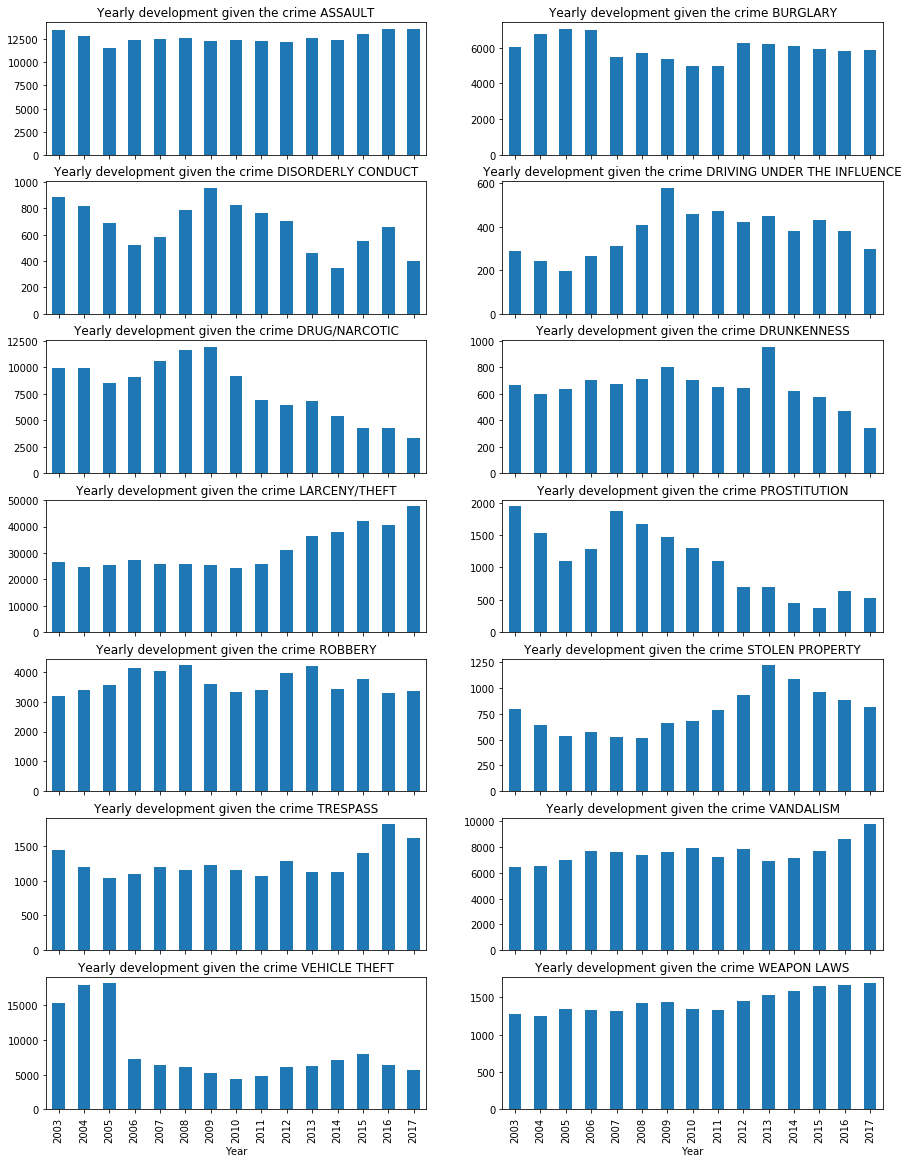

In [7]:
# Display bar-charts
fig, axs = plt.subplots(7, 2, figsize=(15, 20))

i = 0
for crime in sorted(focuscrimes):
    focusCrime = focusData.loc[focusData['Category'] == crime]
    focusCrime = focusCrime.groupby(['Year'])
    createHistogram(focusCrime,crime,axs, i)
    i+=1

plt.show()

## Part 2: Visualizing geo-data

### Plotting a bit
The data is based of a couple of months of data (June-July 2016) for `'DRUG/NARCOTIC'` and the same couple of month for `'LARCENY/THEFT'`.

The geographic data is plotted below in a scatterplot, where the red circles displays each arrest in the category `'DRUG/NARCOTIC'` for in the months june and july for 2016. The blue circles represent each arrest in the category `'LARCENY/THEFT'` for the same time period.

In [8]:
def addCrimeLocations(times, crime, m, fgv, color, data):
    frames = []
    for time in times:
        frames.append(data.loc[data['Date'].str.contains(time)])
    result = pd.concat(frames)
    result = result.loc[result['Category'] == crime]
    
    m = folium.Map([37.77919,-122.41914], zoom_start=12.5)

    for crime in result.values:
        fgv.add_child(folium.CircleMarker(
            location=[crime[10], crime[9]], 
            radius = 3,
            fill=False, 
            color = color, 
            fill_opacity=0.7))
    
    m.add_child(fgv)
    return m

In [9]:
m = folium.Map([37.77919,-122.41914], zoom_start=12.5)
fgv = folium.FeatureGroup(name="Locations")

m = addCrimeLocations(['06/2016','07/2016'], 'LARCENY/THEFT',m, fgv, 'Red', focusData)
m = addCrimeLocations(['06/2016','07/2016'], 'DRUG/NARCOTIC',m, fgv, 'Blue', focusData)

m.add_child(folium.LayerControl())

Now, let's look at heatmaps. 

The map below contains a heatmap of all arrests for `'DRUG/NARCOTIC'` during June-July 2016 

In [10]:
# Creates a heatmap given a time
def heatMap(times, crime, data):
    frames = []
    for time in times:
        frames.append(data.loc[data['Date'].str.contains(time)])
    result = pd.concat(frames)
    result = result.loc[result['Category'] == crime]
    
    m = folium.Map([37.77919,-122.41914], zoom_start=12.5)

    for crime in result.values:
        folium.CircleMarker([crime[9], crime[10]],
                            radius=15,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(m)

    # convert to (n, 2) nd-array format for heatmap
    arr = result[['Y', 'X']].values

    # plot heatmap
    m.add_child(plugins.HeatMap(arr, radius=17))
    return m

In [11]:
heatMap(['06/2016','07/2016'], 'DRUG/NARCOTIC',focusData)

Now this additional heatmap shows all arrests for `'LARCENY/THEFT'` during June-July 2016 

In [12]:
heatMap(['06/2016','07/2016'], 'LARCENY/THEFT',focusData)

# NOT FINISHED
Commentens on the differences. 
* What can you see using the scatter-plots that you can't see using the heatmaps?
* And *vice versa*: what does the heatmaps help you see that's difficult to distinguish in the scatter-plots?

Comments on the effect on the various parameters for the heatmaps. 
* How do they change the picture?

## Part 3: Some single variable plots

Connecting the dots and recreating plots from DAOST but using our own dataset.

The following plot is a jitter-plot based on SF Police data for the crime `missing people` from 2014-2017 in the timeframe 00.00-00.59  

In [34]:
# Filter data
subset = getSubSet(["/2014","/2015","/2016","/2017"],['MISSING PERSON'],data)
hourData = sorted(subset.loc[subset['Time'].str.contains("00:")]['Time'])
print("The overall amount of missing people in the timeframe are %d" % len(hourData))

The overall amount of missing people in the timeframe are 704


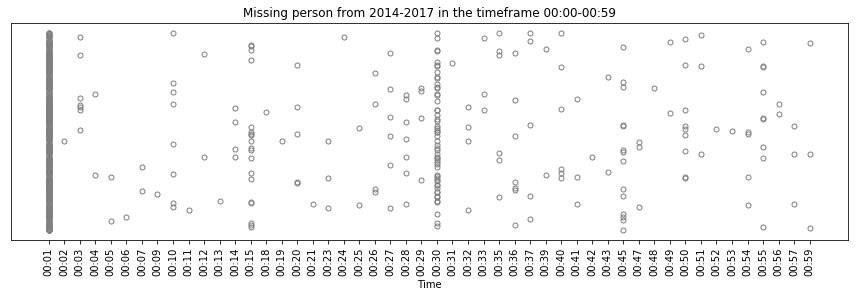

In [35]:
# Create the jitter plot
plt.figure(figsize=(15,4))

y = np.random.random_sample(len(hourData))
plt.plot(hourData,y,'o',markersize=5, color="gray",mfc='none')
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Missing person from 2014-2017 in the timeframe 00:00-00:59')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.show()

Now it's time for histograms. We will now create two versions of **Figure 2-2**. 

The crimes and timeinternal chosen for these histograms are shown below.

In [36]:
subsetMis = getSubSet(["/2014","/2015","/2016","/2017"], ["MISSING PERSON"], data)
subsetFra = getSubSet(["/2014","/2015","/2016","/2017"],['FRAUD'],data)
print("Amount of data for Fraud and missing person crimes are %d and %d" % (len(subsetFra),len(subsetMis)))

Amount of data for Fraud and missing person crimes are 11326 and 18223


Then taking the latitude part of the GPS coordinates for each crime and bining the latitudes so that there are 50 bins across the city of SF.

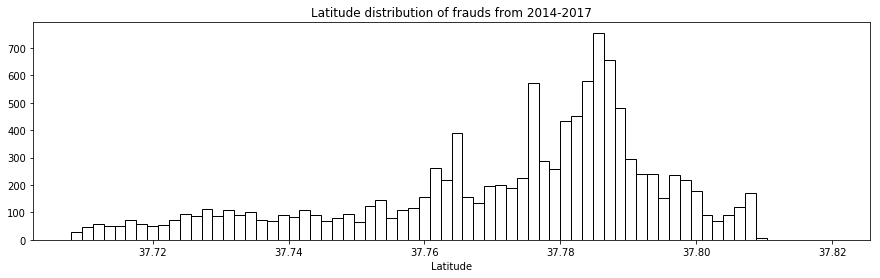

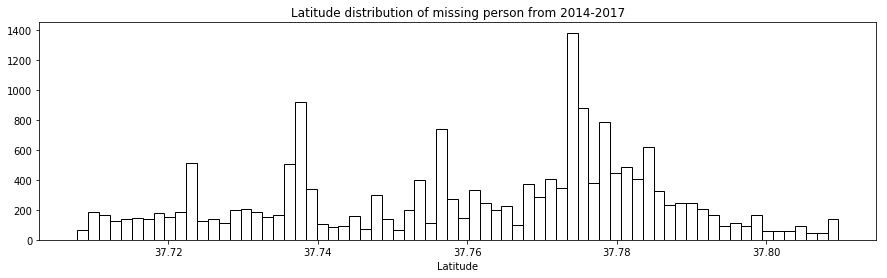

In [37]:
plt.figure(figsize=(15,4))
plt.hist(sorted(subsetFra['Y']), bins=70,fill=False)
plt.title('Latitude distribution of frauds from 2014-2017')
plt.xlabel('Latitude')
plt.show()

plt.figure(figsize=(15,4))
plt.hist(sorted(subsetMis['Y']), bins=70,fill=False)
plt.title('Latitude distribution of missing person from 2014-2017')
plt.xlabel('Latitude')
plt.show()

Now we want to make the kernel density plot

In [38]:
subset = getSubSet(["/2013","/2014","/2015","/2016","/2017"],['MISSING PERSON'],data)
hourDataRaw = subset.loc[subset['Time'].str.contains("00:")]['Time']
hourData = sorted(hourDataRaw)
           
# Find the minute number and make it to an integer
for index, item in enumerate(hourData):
    hourData[index] = int(hourData[index][3:5])

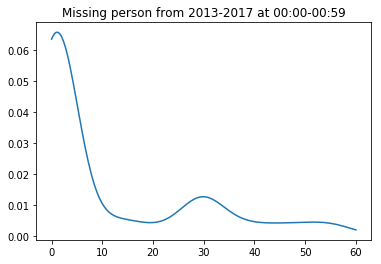

In [39]:
density = gaussian_kde(hourData)
xs = np.linspace(0,60,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.title('Missing person from 2013-2017 at 00:00-00:59')
plt.show()

Now we will grab 25 random timepoints from the dataset 

[1, 1, 1, 15, 30, 1, 1, 1, 1, 1, 30, 15, 30, 1, 1, 1, 10, 1, 1, 1, 10, 50, 1, 59, 1]


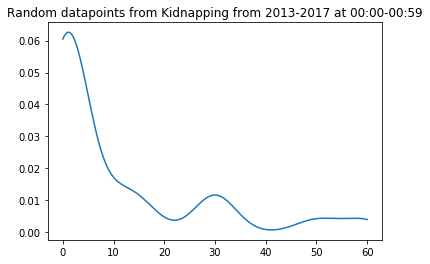

In [40]:
# Find the minute number and make it to an integer
randomData = [] 
for i in range(25):
    randomData.append(random.choice(hourData))
density = gaussian_kde(randomData)
xs = np.linspace(0,60,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.title('Random datapoints from Kidnapping from 2013-2017 at 00:00-00:59')
plt.show()

# NOT FINISHED
Does this shed light on why I think KDEs can bee misleading? 

To understand to true distribution, the following probability plots are made

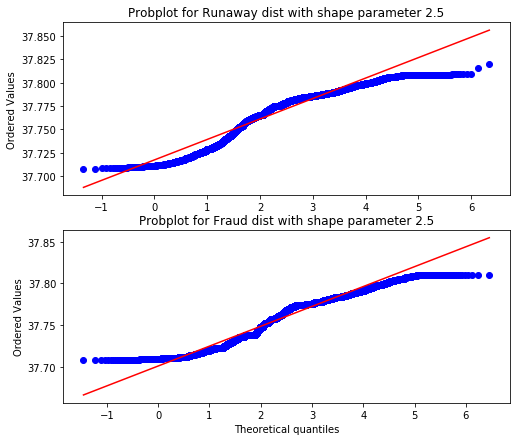

In [43]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(211)
stats.probplot(subsetFra['Y'], sparams=(2.5,), plot=ax)
ax.set_title("Probplot for Runaway dist with shape parameter 2.5")
ax.set_xlabel("")

ax = fig.add_subplot(212)
stats.probplot(subsetMis['Y'], sparams=(2.5,), plot=ax)
ax.set_title("Probplot for Fraud dist with shape parameter 2.5")

plt.show()

**Now box plots**. Here, we wnat to use the box plots to visualize fluctuations of how many crimes happen per day. For the 14 focus crimes defined last week.

Calulating the **number of crimes per day** within each category for the entire duration of the data (this should result in 15 datasets, on for each focus crime).


In [17]:
countData = {}
for crime in focuscrimes:
    subset = getSubSet([''],[crime],data)
    countData[crime] = subset.groupby(['Date']).count()

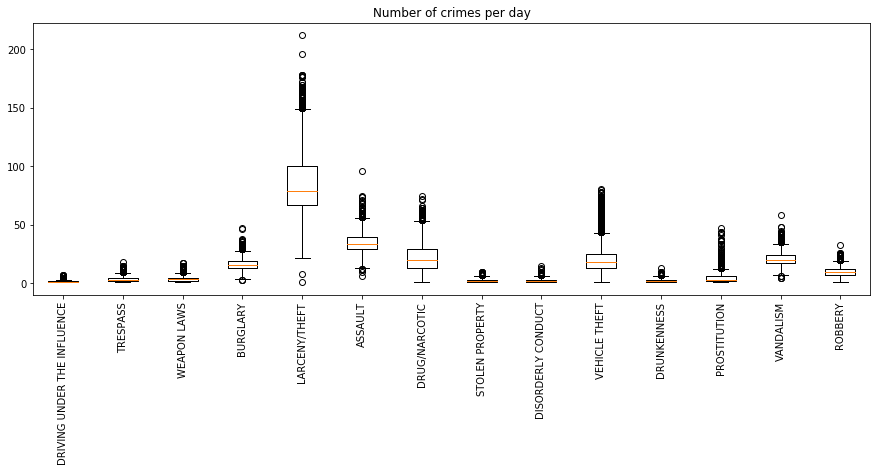

In [18]:
# http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

fig = plt.figure(1, figsize=(15, 5))

ax = fig.add_subplot(111)

data_to_plt = [countData[crime]['Category'] for crime in focuscrimes]
bp = ax.boxplot(data_to_plt)
ax.set_xticklabels(focuscrimes, rotation='vertical')
ax.set_title('Number of crimes per day')

plt.show()

Or in a different representation:

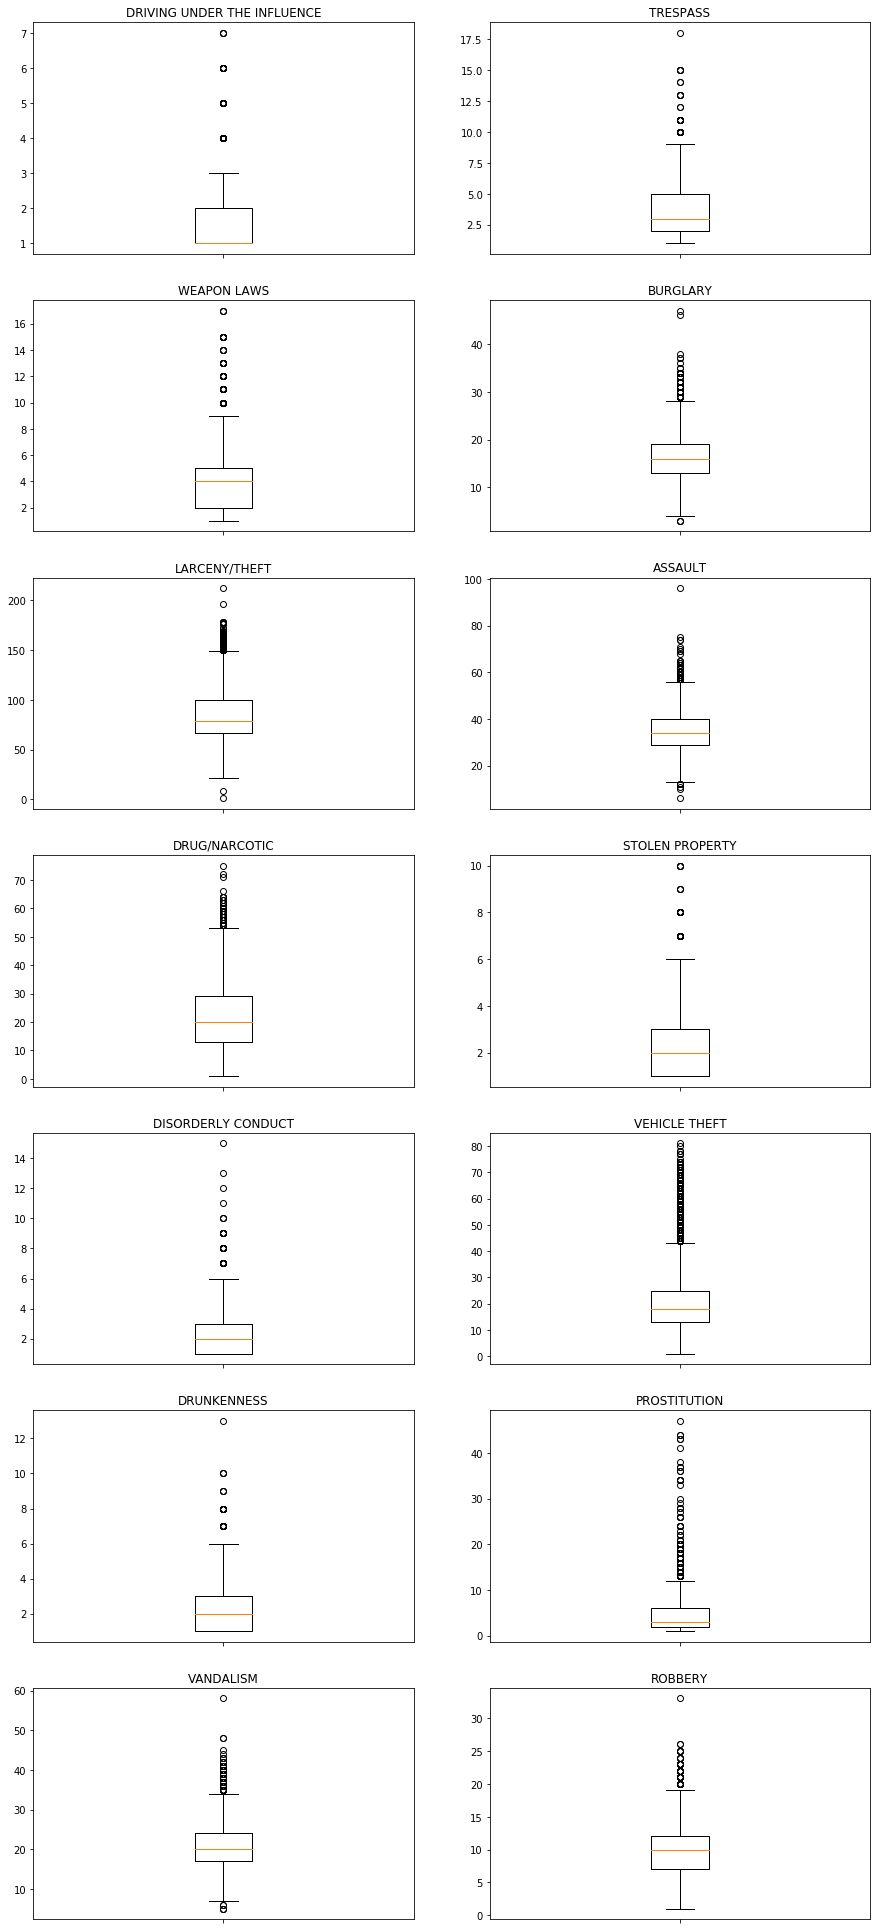

In [46]:
fig = plt.figure(figsize=(15,40))

i = 1
for crime in focuscrimes:
    ax = fig.add_subplot(8,2,i)
    ax.boxplot(countData[crime]['Category'])
    ax.set_title(crime)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    i+=1
plt.show()

# NOT FINISHED
What does this plot reveal that you can't see in the plots from last time?

## Part 4: Decision tree

*Exercise*: Decision trees and real-world crime data

The idea for this exercise is to pick two crime-types that have *different geographical patterns* and *different temporal patterns*. We can then use various variables of the real crime data as categories to build a decision tree. I'm thinking we can use
* `DayOfWeek` (`Sunday`, ..., `Saturday`). (Note: Will need to be encodede as integer in `sklearn`)
* `PD District` (`TENDERLOIN`, etc). (Note: Will need to be encodede as integer in `sklearn`)

And we can extract a few more from the `Time` and `Date` variables
* Hour of the day (1-24)
* Month of the year (1-12)

So your job is to **select two crime categories** that (based on your analyses from the past three weeks) have different spatio-temporal patterns. Then we are going to to build is a decision tree (or a random forest) that takes as input the four labels (Hour-of-the-day, Day-of-the-week, Month-of-the-year, and PD-District) of some crime (from one of the two categories) and then tries to predict which category that crime is from.

Some notes/hints
* It is important for your success here to create a balanced dataset, that is, **grab an equal number of examples** from each of the two crime categories. Pick categories with lots of training data. It's probably nice to have something like 10000+ examples of each category to train on. 
* Also, I recommend you grab your training data at `random` from the set of all examples, since we want crimes to be distributed equally over time.
* A good option is the  `DecisionTreeClassifier`.
* Since you have created a balanced dataset, the baseline performance (random guess) is 50%. How good can your classifier get?